In [1]:
# Vorgehen in diesem Notebook:
#     Anzahl der Layer von mit 2 und 3 durchlaufeun lassen.
#     Variable Anzahl Hidden Units pro Hidden Layer
#     Maximale Anzahl HU 500 (folgende sind immer absteigend, random search)
#     Keinen Drop-Out, kein Regularisierung. Konstante Hyperparameter. Selber Optimierer.

#     Unten auch nochmal versuchtes Overfitting auf 100 samples

#     Gerade noch das Problem, dass Verteilung der Predicted locations nicht wirklich passt

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
% cd gdrive/MyDrive/project_sp/drnn

/content/gdrive/MyDrive/project_sp/drnn


In [4]:
import pandas as pd
import tensorflow_probability as tfp
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import seaborn as sns
import time

tfd = tfp.distributions

In [5]:
# load custom modules
from utils import plot, run_training
from model import DDR_MLP

In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))
# Ausgeben ob mit GPU gibt
tf.debugging.set_log_device_placement(False)  #
# RAM für Berechnungen beschränken
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.keras.backend.set_floatx("float64")

Num GPUs Available:  1


# Daten einlesen und bearbeiten

In [8]:
#location of simulated dataset (standardized version)
datapath = pathlib.Path('../fulldatasim_stand.csv')

In [9]:
#load data
dataset = pd.read_csv(datapath)

In [10]:
# ----------------------------------------  Daten bearbeiten  ---------------------------------------------

# shuffle data just in case
data = dataset.sample(frac=1)

#normalise y
data[["norm_mPCS"]] = (data[["mPCS"]] - data[["mPCS"]].mean()) / (
    data[["mPCS"]].max() - data[["mPCS"]].min()
)

In [11]:
## Data Split nach: 80/20
# 80% als Train und validation:
train = data[0 : int(len(data) * 0.8)]
# 20% als Testing:
test = data[int(len(data) * 0.8) : int(len(data))]

# Sicherheitshalber x und y aufteilung nachbauen.
# Sicher ist sicher und ich bin zu faul zum debuggen.
x_train = train.iloc[:, 0:11]
y_train = train.iloc[:, 12]
x_test = test.iloc[:, 0:11]
y_test = test.iloc[:, 12]

# Umformen in TensorFlow Tensoren aus Verlässlichkeit
# Train:
x_train = tf.convert_to_tensor(x_train)
y_train = tf.convert_to_tensor(y_train)
# Test
x_test = tf.convert_to_tensor(x_test)
y_test = tf.convert_to_tensor(y_test)

In [12]:
# How large is the dataset?
N = len(dataset.index)
# number of epochs to train the model for
num_epochs = 30
# how many variables
input_units = 11
# define batch size for training
batch_size = 256
# maximum number of hidden units for random search
max_hidden_units = 500
# learning rate
lr = 0.001
# number hidden layers
num_hidden_layers = 3

In [13]:
#make list for random search of number of hidden units
num_sets = 30 #how many sets to try
hu_list = []

for k in range(num_sets):
  curr_max = max_hidden_units
  curr_hu = []
  for i in range(num_hidden_layers):
    rd_int = np.random.randint(5, curr_max)
    curr_max = rd_int
    curr_hu.append(rd_int)
  hu_list.append(curr_hu)

In [14]:
# ---------------------------------------------   Loss   --------------------------------------------------

negloglik = lambda y, rv_y: -rv_y.log_prob(y)

#2 Hidden Layers

In [15]:
batch_train_losses = []
batch_valid_losses = []
batch_train_mses = []
batch_valid_mses = []
predictions = []

for hu in hu_list:
  model = DDR_MLP(
      num_hidden_layers = 2,
      num_hidden_units = hu
      )
  model, mfit_history = run_training(model = model,
                                     x=x_train,
                                     y=y_train,
                                     loss_fun=negloglik,
                                     num_epochs=25,
                                     batch_size=batch_size,
                                     lr=lr,
                                     optim=tf.keras.optimizers.Adam)
  
  #append metrics to result arrays
  batch_train_losses.append(mfit_history.history['loss'])
  batch_valid_losses.append(mfit_history.history['val_loss'])
  batch_train_mses.append(mfit_history.history['mean_squared_error'])
  batch_valid_mses.append(mfit_history.history['val_mean_squared_error'])

  predictions.append(model(np.array(x_train)))

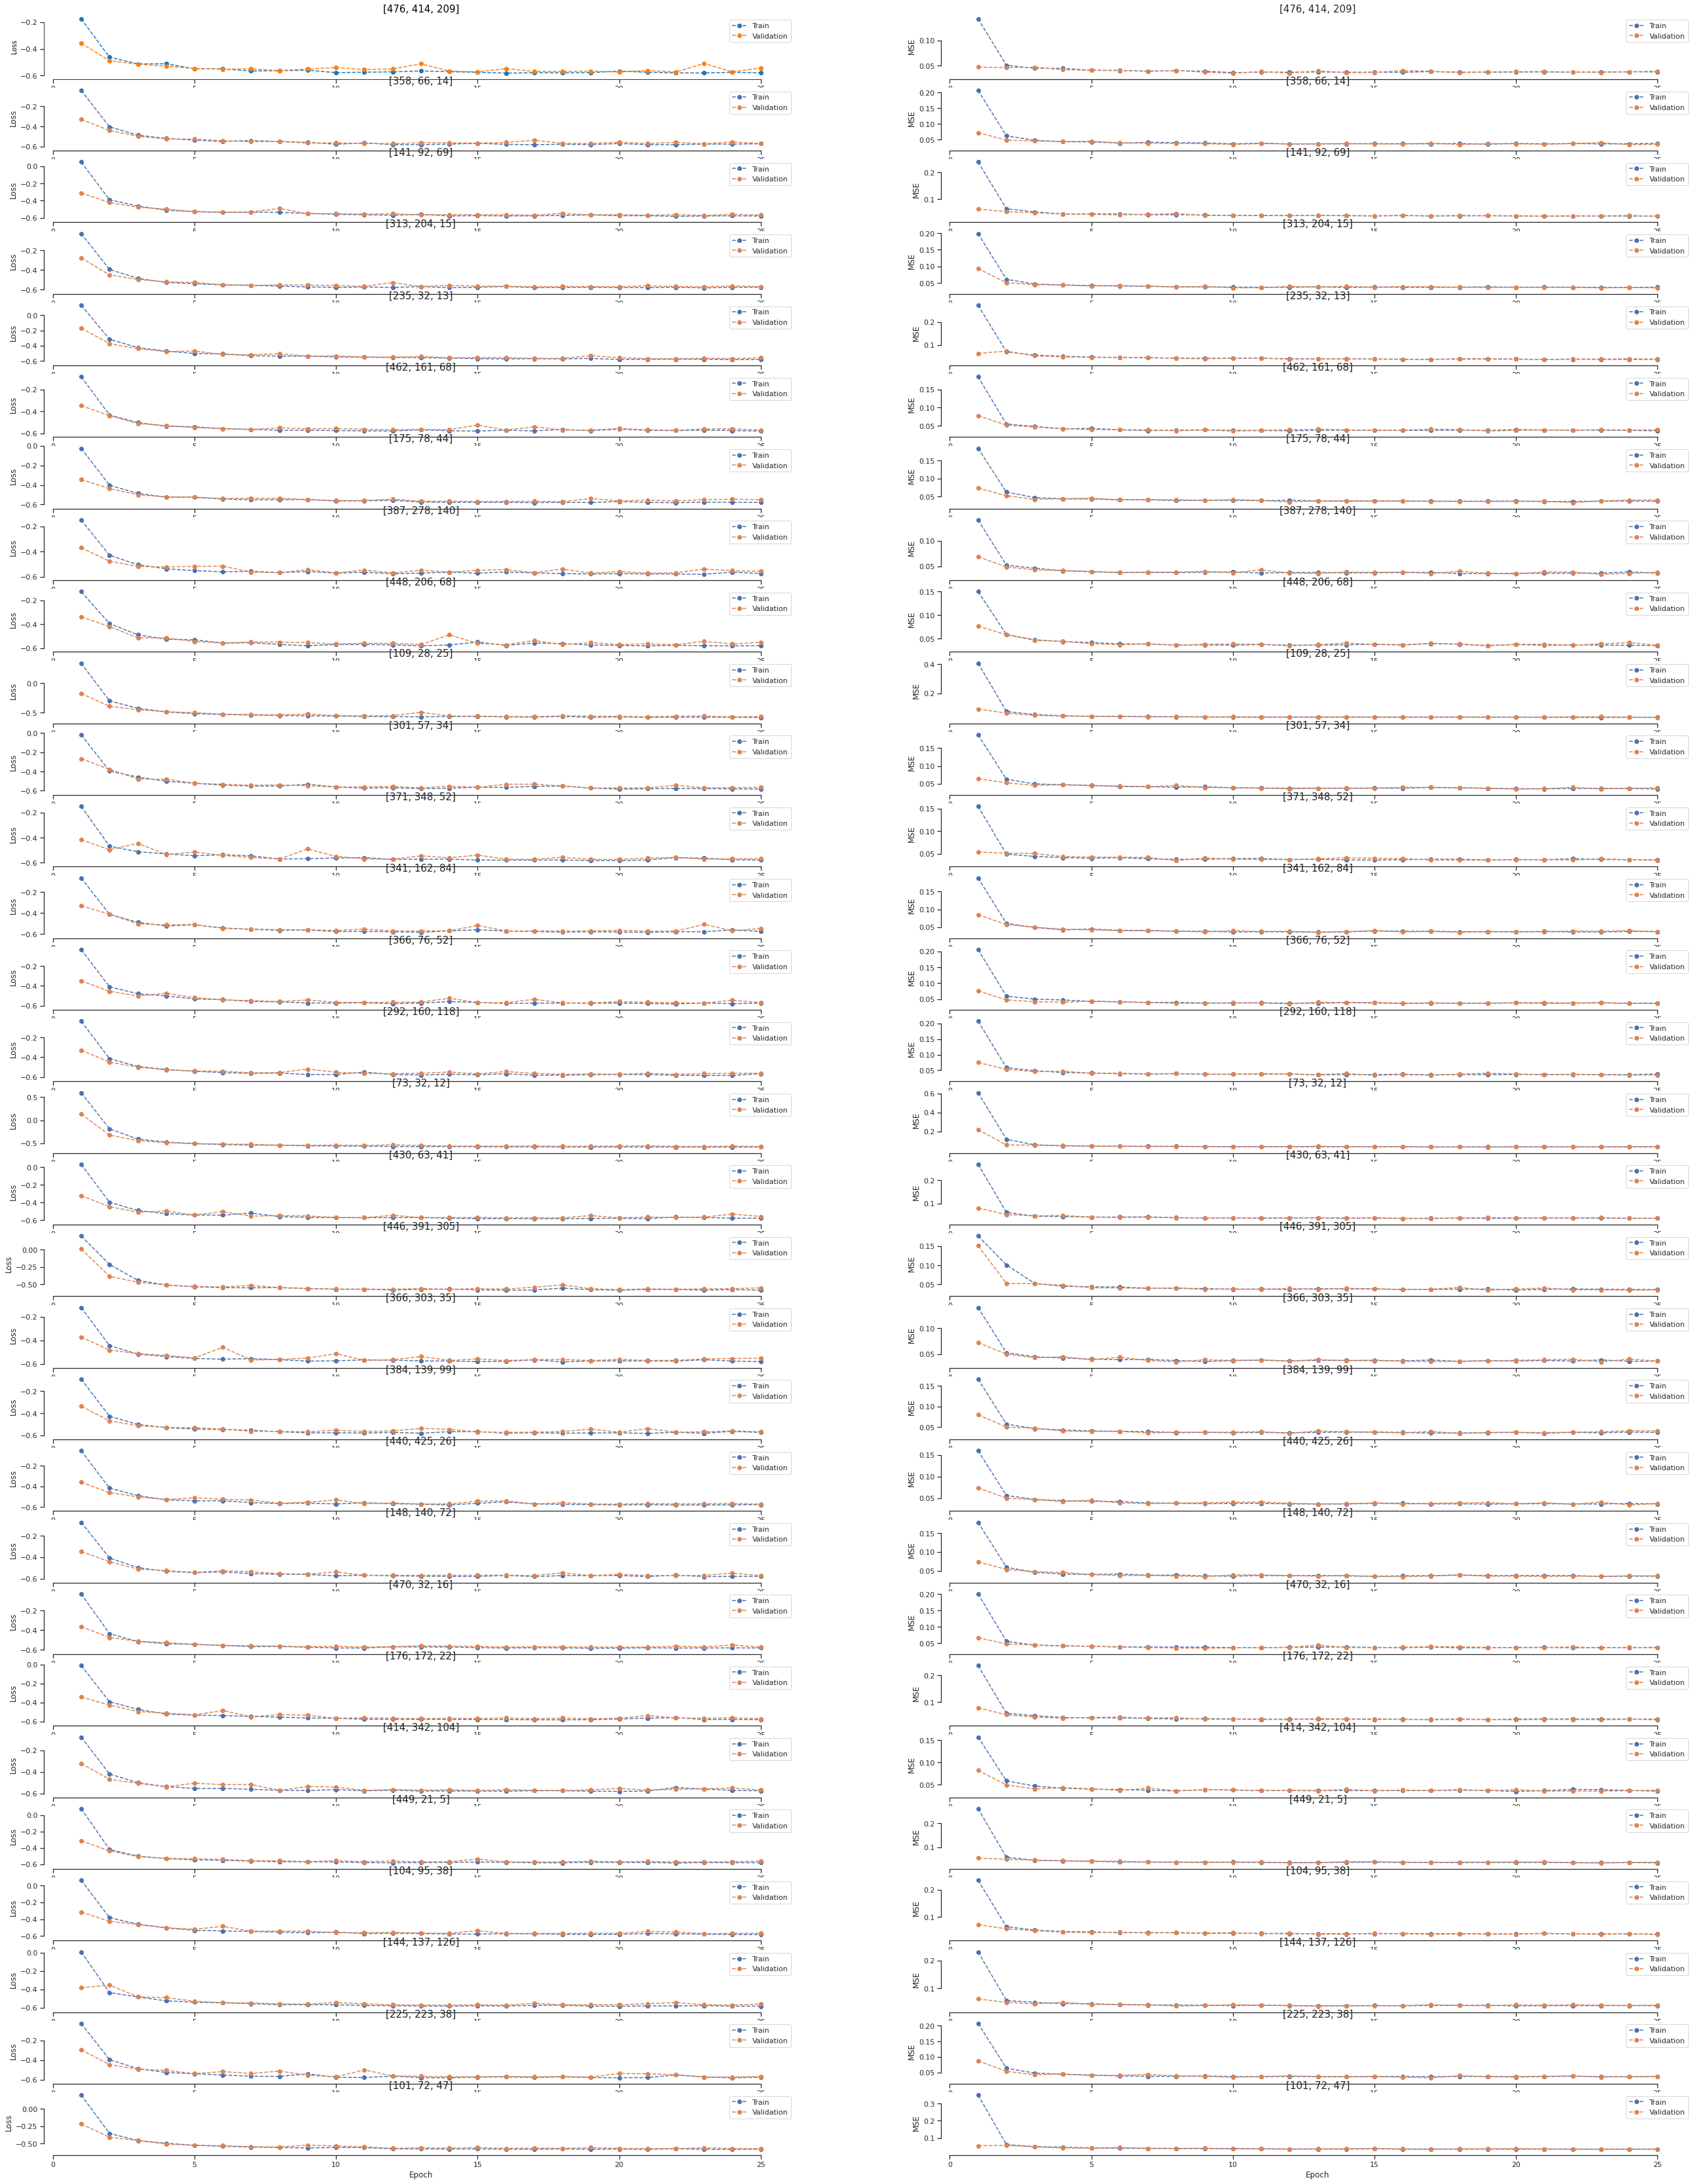

In [16]:
f = plt.figure()
f.set_figwidth(45)
f.set_figheight(60)

k = 0
for i in range(len(hu_list)):
    k += 1
    plt.subplot(len(hu_list), 2, k)
    plot(str(hu_list[i]), "Loss", batch_train_losses[i], batch_valid_losses[i])
    k += 1
    plt.subplot(len(hu_list), 2, k)
    plot(str(hu_list[i]), "MSE", batch_train_mses[i], batch_valid_mses[i])

Text(0.5, 1.0, 'True Values')

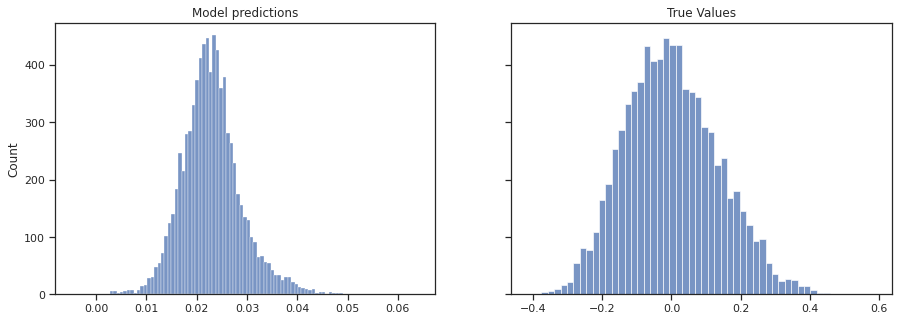

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
# predictions
sns.histplot(ax=axes[0], x = predictions[10].loc)
axes[0].set_title('Model predictions')

# true values
sns.histplot(ax=axes[1], x = y_train)
axes[1].set_title('True Values')

Text(0.5, 1.0, 'True Values')

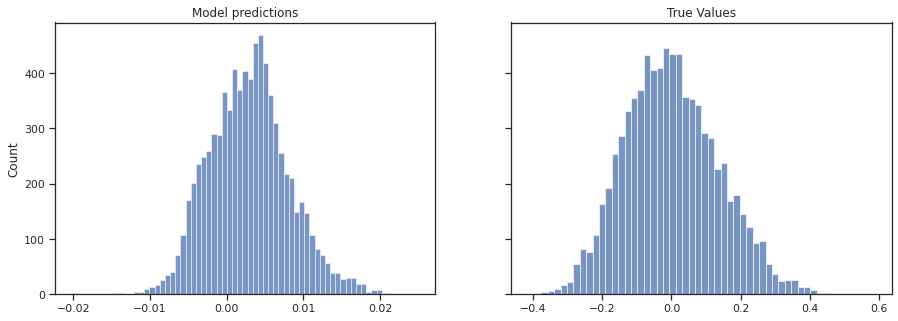

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
# predictions
sns.histplot(ax=axes[0], x = predictions[20].loc)
axes[0].set_title('Model predictions')

# true values
sns.histplot(ax=axes[1], x = y_train)
axes[1].set_title('True Values')

Text(0.5, 1.0, 'True Values')

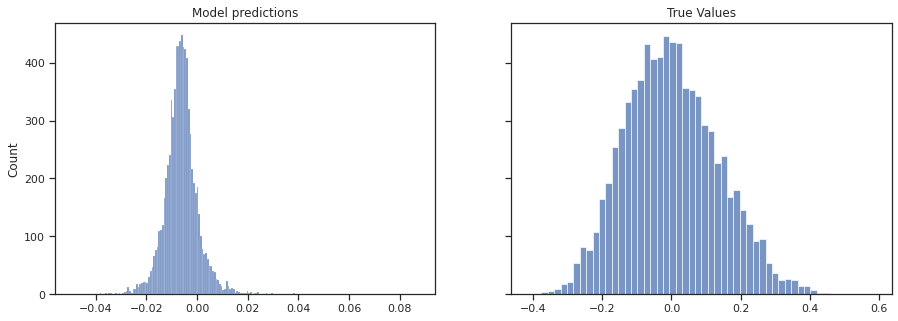

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
# predictions
sns.histplot(ax=axes[0], x = predictions[2].loc)
axes[0].set_title('Model predictions')

# true values
sns.histplot(ax=axes[1], x = y_train)
axes[1].set_title('True Values')

#3 Hidden Layers

In [20]:
batch_train_losses = []
batch_valid_losses = []
batch_train_mses = []
batch_valid_mses = []
predictions = []

for hu in hu_list:
  model = DDR_MLP(
      num_hidden_layers = 3,
      num_hidden_units = hu
      )
  model, mfit_history = run_training(model = model,
                                     x=x_train,
                                     y=y_train,
                                     loss_fun=negloglik,
                                     num_epochs=25,
                                     batch_size=batch_size,
                                     lr=lr,
                                     optim=tf.keras.optimizers.Adam)
  
  #append metrics to result arrays
  batch_train_losses.append(mfit_history.history['loss'])
  batch_valid_losses.append(mfit_history.history['val_loss'])
  batch_train_mses.append(mfit_history.history['mean_squared_error'])
  batch_valid_mses.append(mfit_history.history['val_mean_squared_error'])

  predictions.append(model(np.array(x_train)))

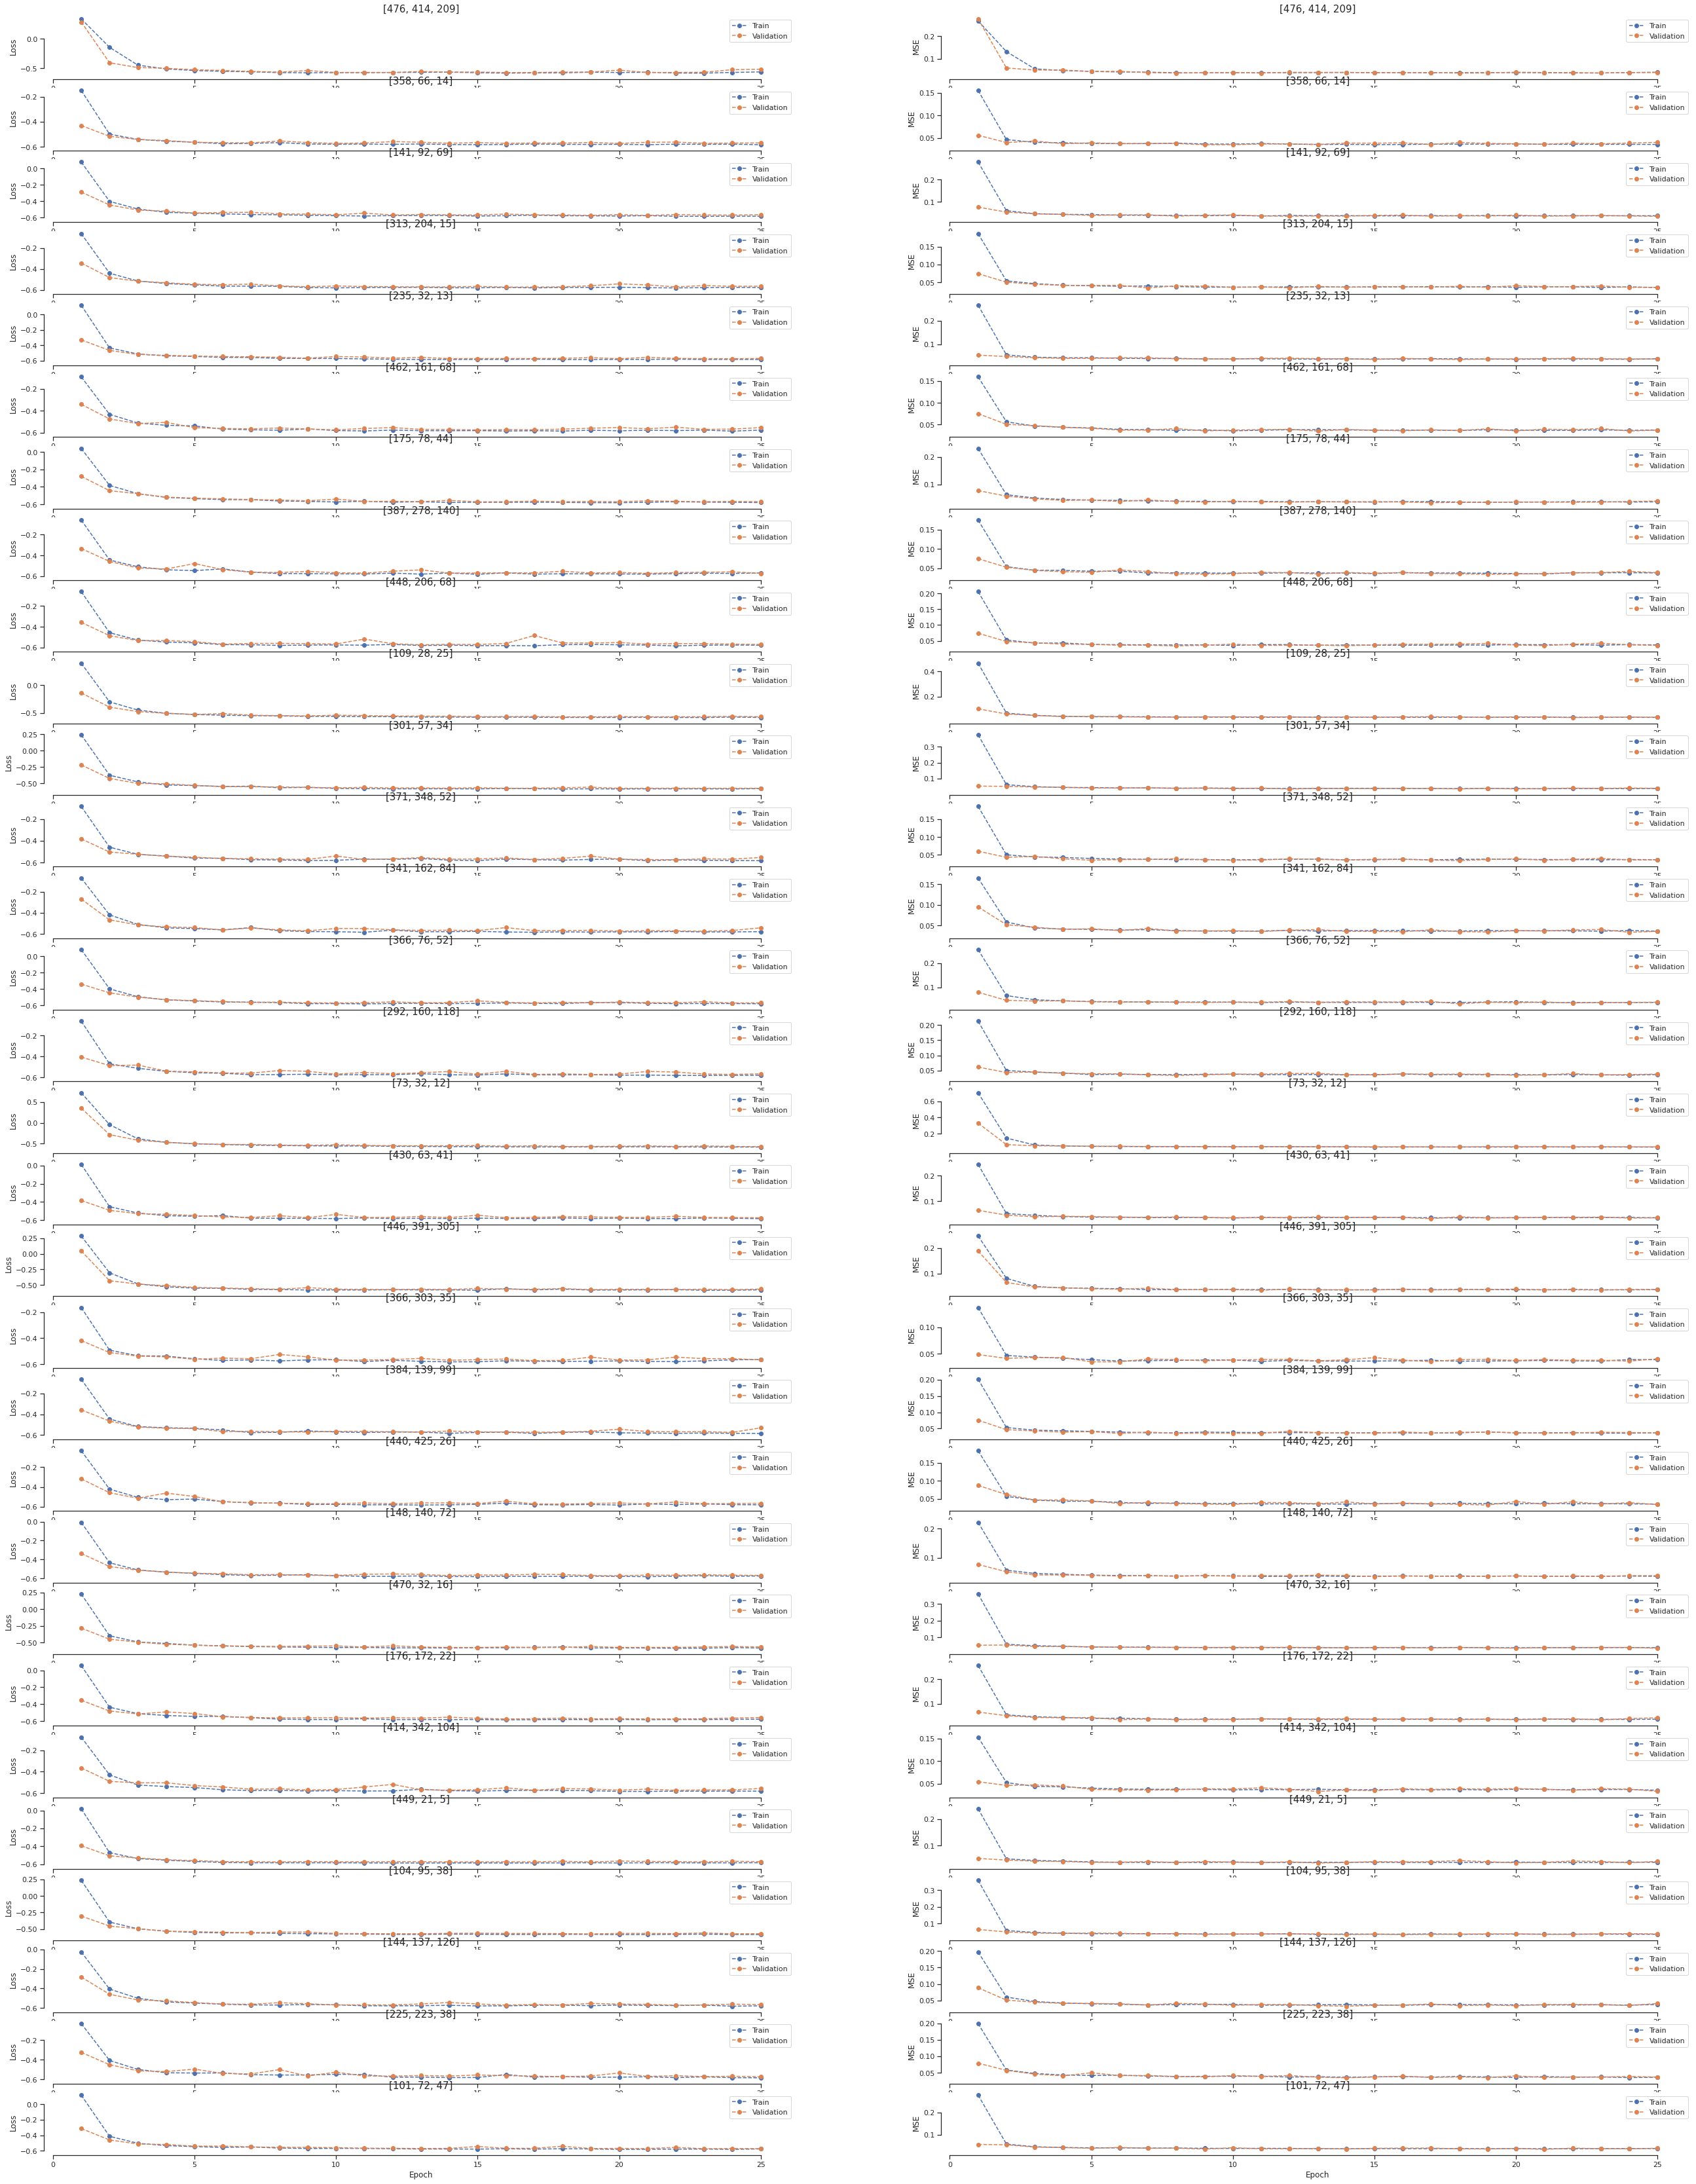

In [21]:
f = plt.figure()
f.set_figwidth(45)
f.set_figheight(60)

k = 0
for i in range(len(hu_list)):
    k += 1
    plt.subplot(len(hu_list), 2, k)
    plot(str(hu_list[i]), "Loss", batch_train_losses[i], batch_valid_losses[i])
    k += 1
    plt.subplot(len(hu_list), 2, k)
    plot(str(hu_list[i]), "MSE", batch_train_mses[i], batch_valid_mses[i])

Text(0.5, 1.0, 'True Values')

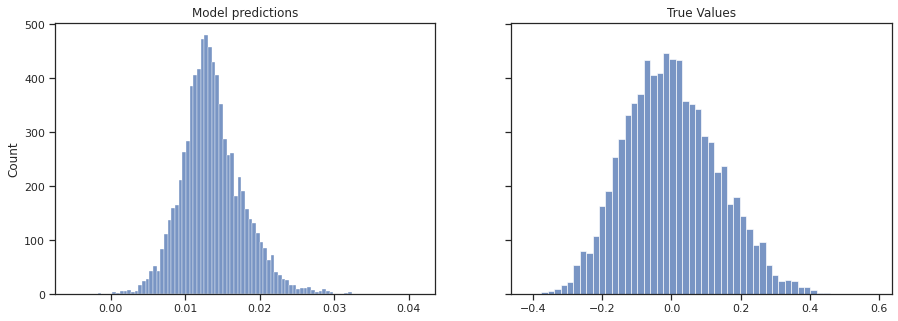

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
# predictions
sns.histplot(ax=axes[0], x = predictions[10].loc)
axes[0].set_title('Model predictions')

# true values
sns.histplot(ax=axes[1], x = y_train)
axes[1].set_title('True Values')

Text(0.5, 1.0, 'True Values')

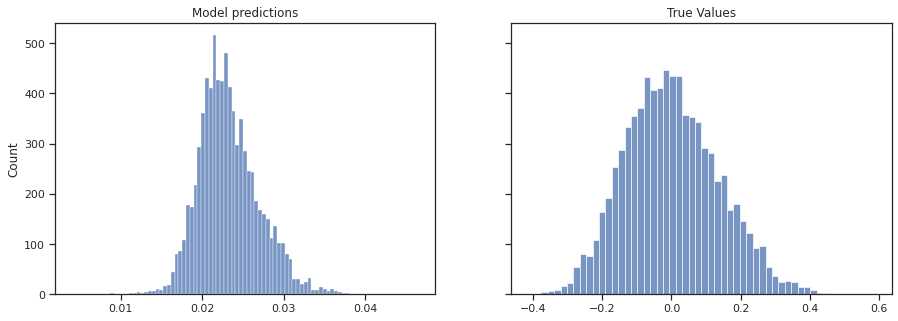

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
# predictions
sns.histplot(ax=axes[0], x = predictions[20].loc)
axes[0].set_title('Model predictions')

# true values
sns.histplot(ax=axes[1], x = y_train)
axes[1].set_title('True Values')

Text(0.5, 1.0, 'True Values')

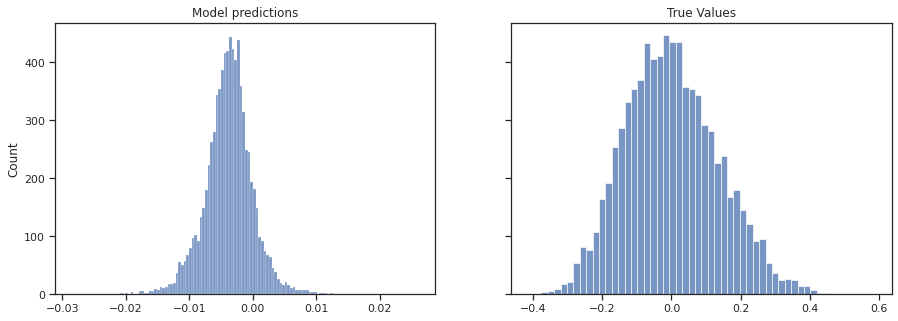

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
# predictions
sns.histplot(ax=axes[0], x = predictions[2].loc)
axes[0].set_title('Model predictions')

# true values
sns.histplot(ax=axes[1], x = y_train)
axes[1].set_title('True Values')

#Overfit on small sample?

In [25]:
batch_train_losses = []
batch_valid_losses = []
batch_train_mses = []
batch_valid_mses = []
predictions = []

for hu in hu_list[1:5]:
  model = DDR_MLP(
      num_hidden_layers = 3,
      num_hidden_units = hu
      )
  model, mfit_history = run_training(model = model,
                                     x=x_train[1:100],
                                     y=y_train[1:100],
                                     loss_fun=negloglik,
                                     num_epochs=25,
                                     batch_size=50,
                                     lr=lr,
                                     optim=tf.keras.optimizers.Adam)
  
  #append metrics to result arrays
  batch_train_losses.append(mfit_history.history['loss'])
  batch_valid_losses.append(mfit_history.history['val_loss'])
  batch_train_mses.append(mfit_history.history['mean_squared_error'])
  batch_valid_mses.append(mfit_history.history['val_mean_squared_error'])

  predictions.append(model(np.array(x_train[1:100])))

Text(0.5, 1.0, 'True Values')

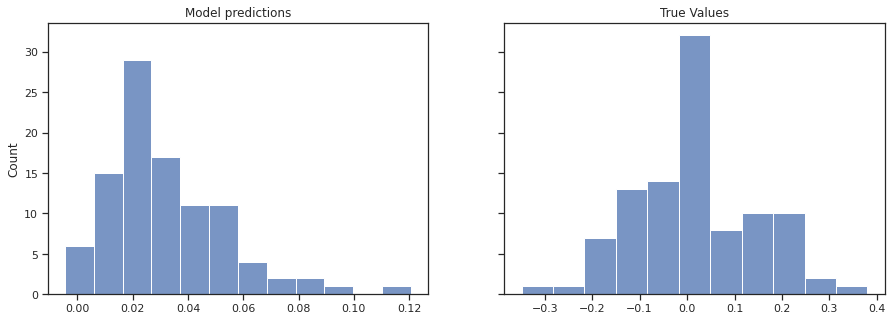

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
# predictions
sns.histplot(ax=axes[0], x = predictions[2].loc)
axes[0].set_title('Model predictions')

# true values
sns.histplot(ax=axes[1], x = y_train[1:100])
axes[1].set_title('True Values')

Text(0.5, 1.0, 'True Values')

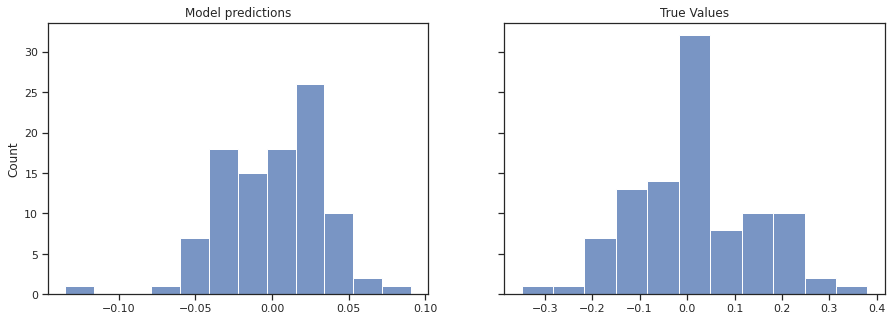

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
# predictions
sns.histplot(ax=axes[0], x = predictions[3].loc)
axes[0].set_title('Model predictions')

# true values
sns.histplot(ax=axes[1], x = y_train[1:100])
axes[1].set_title('True Values')